In [1]:
%%HTML
<style type="text/css">

div.h2 {
    background-color: #000000; 
    color: white; 
    padding: 5px; 
    padding-right: 300px; 
    font-size: 30px; 
    max-width: 1500px; 
    margin-top: 2px;
    margin-bottom: 10px;
}
</style>

<center><h1>Q and A with Google Play Store Data</h1></center>
<center><i>An opinionated analysis of questions that interest me</i></center>
<br>
<br>

The purpose of this kernel is to answer a few questions that have piqued my interest during an initial look at the [Google Play Store Apps dataset](https://www.kaggle.com/lava18/google-play-store-apps).

The analysis for finding these answers are limited by the data at hand and therefore, I strongly advise against taking any action based on the finds of this notebook!

**NOTE:** The dataset used for analysis is 2 years old and we know a lot can change in 2 years. Therefore, the analysis may not be exactly representative of the current scenario. We would need contemporary app data to find that out :)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import re
from IPython.display import display, HTML

In [3]:
try:
    apps = pd.read_csv('../input/googleplaystore.csv')
    reviews = pd.read_csv('../input/googleplaystore_user_reviews.csv')
except:
    print('File names have changed')

<div class='h2'>Data Cleaning</div>

This section contains the code written to clean the data prior to using it for analysis.

In [4]:
# clean data

def clean_size(x):
    
    if 'M' in x:
        x = float(x.replace('M', ''))
        return (x*1000)
    elif 'k' in x:
        return float(x.replace('k', ''))
    elif 'Varies with device':
        return -1 # varies with device
    else:
        return x
    
def compress_ver(x):
    
    if(x=='Varies with device'):
        return x
    else:
        x = str(x)
        x = x.replace('Version', '').replace('version', '').replace('v', '').replace('V', '')
        return x[: (x.find('.')+2)]
    
def split_genre(x):
    
    return x.split(';')

def to_num(x):
    
    return (float(x.replace('$', '')))

def rep_cont_rating(x):
    
    if(x=='Mature 17+' or x=='Adults only 18+'):
        return '17+'
    elif(x=='Teen' or x=='Everyone 10+'):
        return '10+'
    else:
        return x

# fixing the mis-represented entry
cat = apps[(apps['Category']=='1.9') | (apps['Rating']==19.0) | (apps['Installs']=='Free')]
apps = apps[~((apps['Category']=='1.9') & (apps['Rating']==19.0) & (apps['Installs']=='Free'))].reset_index(drop=True)
name = cat.iloc[:,0]
shifted = cat.iloc[:,1:].shift(periods=1, axis=1)
fixed_entry = pd.concat([name, shifted], axis=1)
apps = pd.concat([apps, fixed_entry], axis=0).reset_index(drop=True)
apps.shape

# remove duplicates
apps = apps[~(apps.duplicated())].reset_index(drop=True)

# make size uniform in KB    
apps['Size'] = apps['Size'].apply(clean_size)

# impute missing ratings with -1 and convert to integer
apps['Rating'] = apps['Rating'].fillna(-1)
apps['Rating'] = apps['Rating'].astype(float)

# convert to datetime
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])

# typecast `Reviews` to integer
apps['Reviews'] = apps['Reviews'].astype(int)

# minimize versions to major and minor
apps['Current_ver_min'] = apps['Current Ver'].apply(compress_ver)

# convert `Genres` to lists
apps['Genres'].fillna('Missing', inplace=True)
apps['Genres'] = apps['Genres'].apply(split_genre)

# impute
apps['Type'] = apps['Type'].fillna('Missing')
apps['Category'] = apps['Category'].fillna('Missing')

# convert price
apps['Price'] = apps['Price'].apply(to_num)

# making content rating less ambiguous
apps['Content Rating'] = apps['Content Rating'].apply(rep_cont_rating)

<div class='h2'>Analyzing to Answer</div>

## *Question 1* => If app developer X wanted to develop an app that she wished to monetize, in which category should she release it?

📻 **WHAT'S NEW HERE**

- I am dividing app data on the basis of whether the app is "Paid" or "Free" 

In [5]:
colors = ['#FFD400', '#FF3333']
fig = go.Figure(
    data=go.Pie(labels=['Free', 'Paid'],
               values=[apps['Type'].value_counts()['Free'], apps['Type'].value_counts()['Paid']],
               hole=0.5)
)
fig.update_traces(hoverinfo='label+percent', textinfo='label', textfont_size=15,
                 marker=dict(colors=colors, line=dict(color='#000000', width=1)))
fig.update_layout(
    template='ggplot2',
    font_family='Courier New',
    title = 'Paid apps are rare!',
    title_font_size=30,
    showlegend=False)
fig.show()

Firstly, the "paid app" market is very small when compared to the "free app" market. This might indicate that our developer has to first try to find answers to the questions, *Why are so few apps behind a payment barrier? Is it only because people don't like to pay? Or is there another reason?*



In [6]:
def top_n(df, col, n=5):
    
    temp = pd.DataFrame(df[col].value_counts()).head(n).reset_index()
    return temp

free_paid = apps.groupby(['Category', 'Type'], as_index=False).agg({'App':'count'})
cat_cnt = apps.groupby('Category', as_index=False).agg({'App':'count'})
free_paid_prop = pd.merge(left=free_paid, right=cat_cnt, left_on='Category', right_on='Category')
free_paid_prop['Percent'] = round((free_paid_prop['App_x'] / free_paid_prop['App_y']),2)

In [7]:
paid = apps[apps['Type']=='Paid']
free = apps[apps['Type']=='Free']

fig = make_subplots(rows=2, cols=2,
                    specs=[[{}, {}],
                           [{"colspan": 2}, None]],
                    subplot_titles=('Top 5 Paid App Categories', 'Top 5 Free App Categories',
                                   'Top 10 Categories based on "Paid App Percentage"'))

feature = 'Category'
df = top_n(paid, feature, 5)
colors = ['#3BCCFF',] * 5
colors[1] = colors[3] = '#FF3333'
fig.add_trace(
    go.Bar(
        x=df['index'],
        y=df[feature],
        name='Paid Apps',
        marker_color=colors,
    ), row=1, col=1)

feature = 'Category'
df = top_n(free, feature, 5)
colors = ['#3BCCFF',] * 5
fig.add_trace(
    go.Bar(
        x=df['index'],
        y=df[feature],
        name='Free Apps',
        marker_color=colors,
    ), row=1, col=2)

df = free_paid_prop[free_paid_prop['Type']=='Paid'].sort_values(by='Percent', ascending=False).head(10)
colors = ['#3BCCFF',] * 10
colors[0] = colors[1] = '#FF3333'
fig.add_trace(
    go.Bar(
        x=df['Category'],
        y=df['Percent'],
        name='Paid App %',
        marker_color=colors,
    ), row=2, col=1)

fig.update_yaxes(title_text="Number of Apps", row=1, col=1)
fig.update_yaxes(title_text="Paid App Percentage", row=2, col=1)
    
fig.update_layout(
    template='plotly_dark',
    font_family='Courier New',
    title_text = 'Medical and Personalization apps - Most likely to be paid!',
    title_font_size=15,
    showlegend=False,
    height=700
)

fig.show()

🔍 **METRIC DEFINITION**
- Paid App Percentage = (No. of paid apps in category X) / (No. of total apps in category X)

💡 **INSIGHTS**
- Across the top 5 applications in each of the categories i.e Paid and Free, Medical and Personalization applications are those that are present in Paid's top 5 apps but absent in Free's top 5 apps
-  For every 100 applications belonging to Medical(or Personalization), 21 of these were paid apps
    - This might mean
        - Medical or Personalization apps have larger investment to make, hence they are priced
        - People are willing to pay for Medical or Personalization apps, hence they are priced more frequently than other apps
    - Let's assume our app developer has a lot of resources to back her work. So, she might be interested in going after apps in these 2 categories. But which one?

In [8]:
qual_cats = list(free_paid_prop[free_paid_prop['Type']=='Paid'].sort_values(by='Percent', ascending=False).head(10)['Category'].values)
rateable = apps[apps['Rating']!=-1]
rateable = rateable[rateable['Category'].isin(qual_cats)]
rateable = rateable[rateable['Category'].isin(['PERSONALIZATION', 'MEDICAL'])] # only personalization and medical stuff

def pare_installs(x):
    
    return int(x.replace('+','').replace(',',''))
rateable['Installs'] = rateable['Installs'].apply(pare_installs)

paid = rateable[rateable['Type']=='Paid']

In [9]:
fig = px.scatter(paid, x='Rating', y='Price', color='Category',
                 color_discrete_sequence=['#3BCCFF', '#48FF48'],
                 size= 'Installs', hover_data=['App'], size_max=100,
                 opacity=0.50)
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.99, y=-0.2,
                              xanchor='center', yanchor='top',
                              text='Size of point represents minimum installs of the app',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(
    showlegend=True,
    annotations=annotations,
    template='plotly_dark',
    font_family='Courier New',
    title_text = 'Personalization Apps have been installed far more than Medical Apps',
    title_font_size=15,
    height=400
)

fig.show()

💡 **INSIGHTS**

- Personalization apps have been installed far more than medical apps, as is evident from the size of the green points when compared to the blue ones.
- It can also be noticed that most apps in either category are rated on the higher side on average
- Vargo Anesthesia Mega App is the most expensive at 80$
- VeinSeek has the lowest average rating(2.5, installs=1000+) while FHR 5-Tier 2.0 has the highest average rating(5, installs=500+)

In [10]:

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('On App Prices', 'On Average App Ratings'))

fig.add_trace(go.Violin(y=paid['Price'][paid['Category']=='MEDICAL'],
                               box_visible=False,
                               line_color='#3BCCFF',
                               name='MEDICAL',
                               meanline_visible=True, fillcolor='#3BCCFF', opacity=0.75,
                               ), row=1, col=1)
fig.add_trace(go.Violin(y=paid['Price'][paid['Category']=='PERSONALIZATION'],
                               box_visible=False,
                               line_color='#48FF48',
                               name='PERSONALIZATION',
                               meanline_visible=True, fillcolor='#48FF48', opacity=0.75,
                               ), row=1, col=1)
fig.add_trace(go.Violin(y=paid['Rating'][paid['Category']=='MEDICAL'],
                               box_visible=False,
                               line_color='#3BCCFF',
                               name='MEDICAL',
                               meanline_visible=True, fillcolor='#3BCCFF', opacity=0.75,
                               ), row=1, col=2)
fig.add_trace(go.Violin(y=paid['Rating'][paid['Category']=='PERSONALIZATION'],
                               box_visible=False,
                               line_color='#48FF48',
                               name='PERSONALIZATION',
                               meanline_visible=True, fillcolor='#48FF48', opacity=0.75,
                               ), row=1, col=2)

fig.update_yaxes(title_text="Price of App($)", row=1, col=1)
fig.update_yaxes(title_text="Rating of App(0-5)", row=1, col=2)

fig.update_layout(
    template='plotly_dark',
    font_family='Courier New',
    title_text = 'Comparison between Medical Apps and Personalization Apps',
    title_font_size=15,
    showlegend=False,
    yaxis_title='Price of App($)',
    height=400
)

fig.show()

💡 **INSIGHTS**

- Medical apps are priced way higher than Personalization apps
    - Median price of Medical apps = 5.49\$
    - Median price of Personalization apps = 1.49\$
    - Therefore, if well received, Medical apps can generate far more revenue than Personalization apps
- When it comes to rating, both categories have the same median rating of 4.4
    - But, Medical apps have more bad performers when compared to Personalization apps
    

### *Answer* => The app developer could make an app for the Medical category, provided she is able to make something useful and well received by her customers.

## *Question 2* => Can the version numbers of apps tell a story?

My first instinct was to discard the version numbers. But, what if these version numbers could tell a story? Let's find out :)

📻 **WHAT'S NEW HERE**

- For this part, I am extracting only the major version of an app
- This is based on the assumption that a version number is represented as major.minor.patch ([Source](https://medium.com/@GabEarnsh/versioning-mobile-app-releases-like-a-pro-25137766150a))
- Another assumption made here is that an app is considered as having a second or more major version release if it's major version is >= 2 (Even in cases where version starts at 0). This is because the provided data does not provide an insight about all releases for each app.

In [11]:
def extract_major(x):
    try:
        return int(float(x))
    except:
        if(x=='Varies with device'):
            return -1 # indicates varies with device
        else:
            return -2 # indicates different format
        
def df_ver(v):
    
    return apps[apps['Major_ver']==v]

def second_maj(x):
    
    if x>=2:
        return 'Yes'
    else:
        return 'No'

apps['Major_ver'] = apps['Current_ver_min'].apply(extract_major)
apps = apps.drop(['Current_ver_min'], axis=1)

There exists a diverse range of major versions for all apps. The unique major versions for the apps in Playstore at the time of data collection for this dataset are depicted below.

In [12]:
print('All major versions for the apps in this dataset(-1 and -2 are special cases; hence ignore):')
apps['Major_ver'].sort_values(ascending=False).unique()

All major versions for the apps in this dataset(-1 and -2 are special cases; hence ignore):


array([1000000,  300000,    5055,    4541,    3000,    2018,    2017,
          2014,    1805,    1004,     263,     220,     176,     130,
           112,     102,      99,      79,      70,      69,      68,
            65,      60,      57,      53,      50,      47,      43,
            42,      41,      40,      39,      37,      35,      33,
            32,      31,      30,      29,      28,      27,      26,
            25,      24,      23,      22,      21,      20,      19,
            18,      17,      16,      15,      14,      13,      12,
            11,      10,       9,       8,       7,       6,       5,
             4,       3,       2,       1,       0,      -1,      -2],
      dtype=int64)

👽 **PECULIARITIES**

- Version numbers like 1000000, 30000, 5055 etc. => Do developers of these apps actually have these many major versions?
- Version numbers like 2018, 2017, 2014 => They look like years.
- This brings us to the fundamental question => Are all apps on Play Store subject to a uniform way of versioning? Through this data it definitely does not seem like it.

📝 **NOTE**

- The version numbers -1 and -2 have been explicitly introduced by me.
   * -1 signifies apps that have versions that vary with device
   * -2 signifies apps that had a version that did not conform to the major.minor.patch pattern
- For the sake of analysis, I am analyzing all apps by bucketing them on the basis of their versions
    - First bucket => Version number < 1000 (Infact, the max. version no. in this bucket is only 263)
    - Second bucket => Version number > 1000 and Version number < 6000
    - Third bucket => Version number > 6000

In [13]:
ver_nos = pd.DataFrame(apps['Major_ver'].value_counts().head(10)).\
    reset_index().sort_values(by='Major_ver', ascending=False)
colors = ['#3BCCFF',] * 10
colors[0] = '#FF3333'
colors[2] = '#FFD400'
fig = go.Figure()
fig.add_trace(go.Bar(
    x=ver_nos['index'],
    y=ver_nos['Major_ver'],
    name='Major version = 1',
    marker_color=colors
))

annotations = [dict(x=-1, y=900, text='Varies with Device', arrowhead=1, ax=30, ay=-70),
               dict(x=1, y=3000, text='Major Version = 1', arrowhead=1, ax=120, ay=-40)]

fig.update_layout(
    annotations=annotations,
    showlegend=False,
    template='plotly_dark',
    font_family='Courier New',
    title_text = "Top 10 Most Common Version Numbers on Playstore" ,
    title_font_size=15,
    xaxis_title='Major Version Number of App',
    yaxis_title='Number of Apps',
    height=400
)
fig.show()

💡 **INSIGHTS**

- Most apps on the playstore are versioned at 1 (major version)
- There exist a considerable number of apps that have major versions that "vary with device"
- As version numbers increase, the number of corresponding apps are lesser

What about those very large(extremely large) version numbers? Were they mistakes?  

Nope.

In [14]:
def plot_table(df, exclude=[]):
    """ Plot table with plotly """
    
    
    colorscale = [[0, '#FF3333'],[.5, '#FFFFFF'],[1, '#FFFFFF']]
    fig =  ff.create_table(df[['App', 'Category', 'Rating', 'Reviews', 'Installs',
                                        'Current Ver', 'Last Updated']].sort_values(by='Last Updated'),
                           colorscale=colorscale)
    fig.show()

# prep some data

apps_ver_b1 = apps[(apps['Major_ver']<1000) & (apps['Major_ver']>=0) & (apps['Rating']>=0)]
apps_ver_b2 = apps[(apps['Major_ver']<6000) & (apps['Major_ver']>=1000) & (apps['Rating']>=0)]
apps_ver_b3 = apps[(apps['Major_ver']>=6000) & (apps['Rating']>=0)]

apps_ver_b1['Sec_maj'] = apps_ver_b1['Major_ver'].apply(second_maj)

In [15]:
plot_table(apps_ver_b3)

💡 **INSIGHTS**

- The above table represents all apps that had very large major versions
- On careful observation, we see two things
    - All are "MEDICAL" apps
    - All of them but 2 have this abbreviation 'AH'. What does that mean?
- None of these apps are big in terms of their installs and neither do they boast of a large number of reviews. Cool. So what?

Let's hypothesize here. Does it not seem like these apps with 'AH' are probably made by the same developer who likes versioning their apps starting from 300000? The number of installs are pretty low, so maybe these are utility apps used by only a specific set of users. Even the 'Last Updated' dates indicate some kind of relation between these apps and their versions.  

**We are right in our hypothesis!**  

Through a search on Appstore, I was able to find out that 'AH' stood for Animal Hospital. And these apps were developed by [Vet2Pet](https://play.google.com/store/apps/developer?id=Vet2Pet). They develop custom apps for veterinary doctors and clinics.

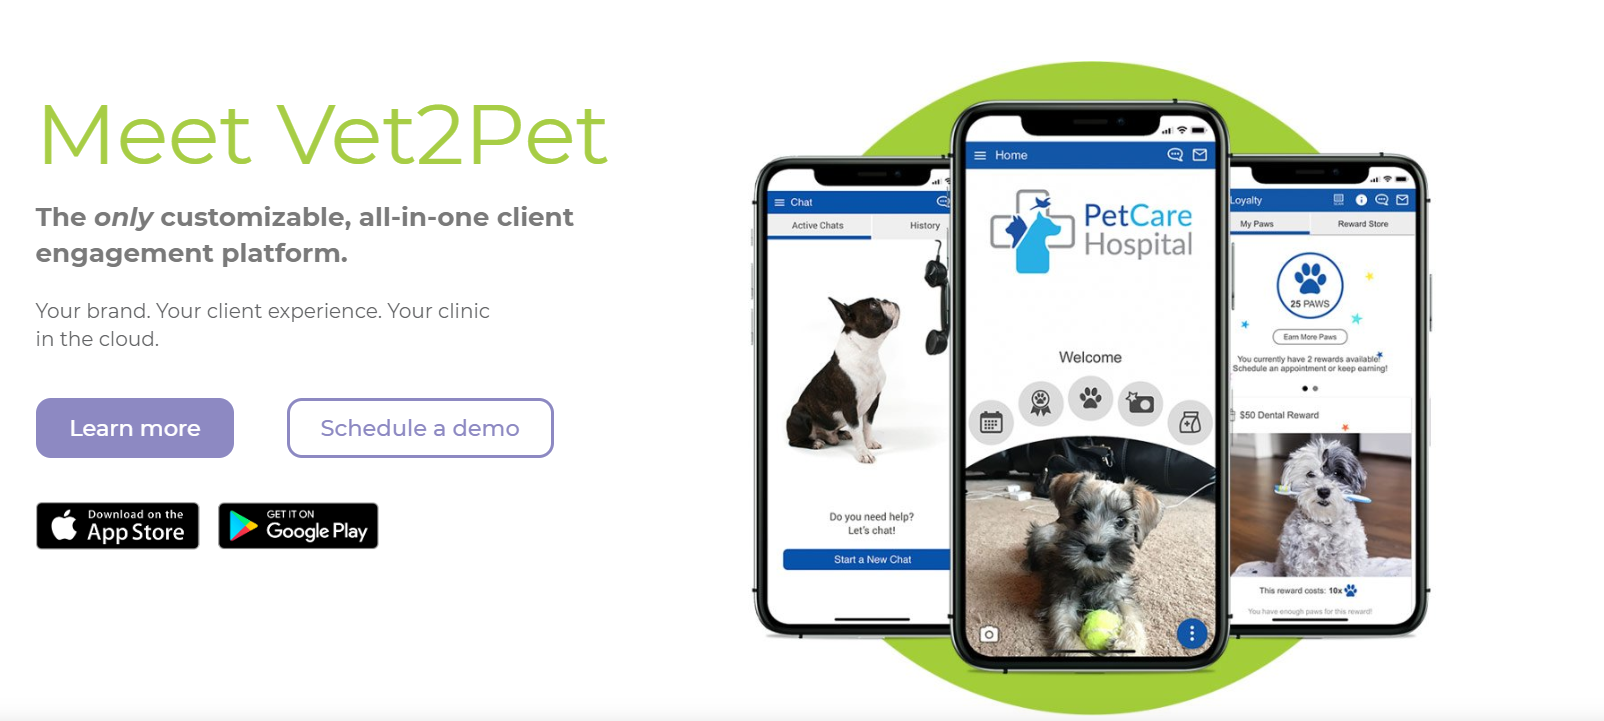

### *Answer* => Yes. The version numbers have given 2 stories here. The first is about how most apps on play store at the time of this data collection were in their first major version. The second is a more poignant story of an app that helps support veterinary doctors so that they can care well for their "furry" clients :)